In [14]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_absolute_error,
    r2_score
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.1)

In [15]:
# =====================================================
# 1. Setup Paths
# =====================================================
PROC = Path('../data/processed')
MODELS = Path('../models')
REPORTS = Path('../reports')
for p in [MODELS, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

In [16]:
# =====================================================
# 2. Load Train / Val / Test
# =====================================================
train = pd.read_csv(PROC / 'train.csv')
val = pd.read_csv(PROC / 'val.csv')
test = pd.read_csv(PROC / 'test.csv')
print(f"✅ Data Loaded — Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")

✅ Data Loaded — Train: (11987, 53), Val: (2116, 53), Test: (2489, 53)


In [17]:
# =====================================================
# 3. Add Agronomic Rule Features
# =====================================================
def add_rule_features(df):
    """Add domain-driven features for model learning."""
    df = df.copy()
    df['High_N_Need'] = (df['Nitrogen_Level'] < 100).astype(int)
    df['High_P_Need'] = (df['Phosphorus_Level'] < 30).astype(int)
    df['High_K_Need'] = (df['Potassium_Level'] < 100).astype(int)
    return df

In [18]:
# =====================================================
# 4. Prepare Classification and Regression Data
# =====================================================
X_train_clf = train.drop(['Fertilizer_Type', 'Recommended_Quantity_kg_per_acre'], axis=1)
y_train_clf = train['Fertilizer_Type']

X_val_clf = val.drop(['Fertilizer_Type', 'Recommended_Quantity_kg_per_acre'], axis=1)
y_val_clf = val['Fertilizer_Type']

X_train_reg = X_train_clf.copy()
y_train_reg = train['Recommended_Quantity_kg_per_acre']

X_val_reg = X_val_clf.copy()
y_val_reg = val['Recommended_Quantity_kg_per_acre']

# Add engineered rule-based columns
X_train_clf = add_rule_features(X_train_clf)
X_val_clf = add_rule_features(X_val_clf)
X_train_reg = add_rule_features(X_train_reg)
X_val_reg = add_rule_features(X_val_reg)

In [19]:
# =====================================================
# 5. Balance the Training Data for Classifier
# =====================================================
print("🔍 Balancing Fertilizer Classes...")
print("Before balancing:")
print(y_train_clf.value_counts(normalize=True))

max_count = y_train_clf.value_counts().max()
frames = []
for fert_type, subset in train.groupby('Fertilizer_Type'):
    subset_up = resample(subset, replace=True, n_samples=max_count, random_state=42)
    frames.append(subset_up)

train_balanced = pd.concat(frames)
print("\nAfter balancing:")
print(train_balanced['Fertilizer_Type'].value_counts())

X_train_clf = train_balanced.drop(['Fertilizer_Type', 'Recommended_Quantity_kg_per_acre'], axis=1)
y_train_clf = train_balanced['Fertilizer_Type']
X_train_clf = add_rule_features(X_train_clf)

🔍 Balancing Fertilizer Classes...
Before balancing:
Fertilizer_Type
Compost    0.639693
Urea       0.111204
Potash     0.099191
DAP        0.080754
Mixed      0.069158
Name: proportion, dtype: float64

After balancing:
Fertilizer_Type
Compost    7668
DAP        7668
Mixed      7668
Potash     7668
Urea       7668
Name: count, dtype: int64


In [20]:
# =====================================================
# 6. Save Final Feature Columns
# =====================================================
final_features = X_train_clf.columns.tolist()
joblib.dump(final_features, MODELS / 'feature_columns.pkl')
print(f"✅ Saved feature order to: {MODELS.resolve() / 'feature_columns.pkl'}")

✅ Saved feature order to: C:\Users\sasik\OneDrive\Desktop\AIML Project\models\feature_columns.pkl


In [22]:
# =====================================================
# 7. Train Models (Fixed — handles text columns)
# =====================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from pathlib import Path
import joblib

# -------------------------------
# 1. Encode Non-Numeric Columns
# -------------------------------
def encode_categoricals(df):
    """Encodes all object/categorical columns with LabelEncoder."""
    df_encoded = df.copy()
    encoders = {}
    
    cat_cols = df_encoded.select_dtypes(exclude=[np.number]).columns
    print(f"🔤 Encoding categorical columns: {list(cat_cols)}")

    for col in cat_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        encoders[col] = le
    
    return df_encoded, encoders

X_train_clf_encoded, encoders_clf = encode_categoricals(X_train_clf)
X_train_reg_encoded, encoders_reg = encode_categoricals(X_train_reg)
X_val_clf_encoded, _ = encode_categoricals(X_val_clf)
X_val_reg_encoded, _ = encode_categoricals(X_val_reg)

# -------------------------------
# 2. Initialize Models
# -------------------------------
clf_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=16,
    class_weight='balanced',
    random_state=42
)

reg_rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=14,
    random_state=42
)

# -------------------------------
# 3. Train Models
# -------------------------------
print("🚀 Training models...")
clf_rf.fit(X_train_clf_encoded, y_train_clf)
reg_rf.fit(X_train_reg_encoded, y_train_reg)
print("✅ Training Complete!")

# -------------------------------
# 4. Evaluate Models
# -------------------------------
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score

preds_clf_rf = clf_rf.predict(X_val_clf_encoded)
preds_reg_rf = reg_rf.predict(X_val_reg_encoded)

print("\n📊 Random Forest Classifier Results")
print("Accuracy:", accuracy_score(y_val_clf, preds_clf_rf))
print("Classification Report:\n", classification_report(y_val_clf, preds_clf_rf))

mae = mean_absolute_error(y_val_reg, preds_reg_rf)
r2 = r2_score(y_val_reg, preds_reg_rf)
print(f"Regression MAE: {mae:.2f}")
print(f"Regression R²: {r2:.3f}")

# -------------------------------
# 5. Save Models and Encoders
# -------------------------------
MODELS = Path('../models')
MODELS.mkdir(parents=True, exist_ok=True)

joblib.dump(clf_rf, MODELS / 'rf_classifier.pkl')
joblib.dump(reg_rf, MODELS / 'rf_regressor.pkl')
joblib.dump(encoders_clf, MODELS / 'rf_label_encoders.pkl')

print(f"\n✅ Models and encoders saved successfully to: {MODELS.resolve()}")


🔤 Encoding categorical columns: ['District_Name', 'Soil_color', 'Crop', 'Fertilizer', 'Link', 'Soil Type', 'Crop Type', 'Fertilizer Name', 'Soil', 'Remark']
🔤 Encoding categorical columns: ['District_Name', 'Soil_color', 'Crop', 'Fertilizer', 'Link', 'Soil Type', 'Crop Type', 'Fertilizer Name', 'Soil', 'Remark']
🔤 Encoding categorical columns: ['District_Name', 'Soil_color', 'Crop', 'Fertilizer', 'Link', 'Soil Type', 'Crop Type', 'Fertilizer Name', 'Soil', 'Remark']
🔤 Encoding categorical columns: ['District_Name', 'Soil_color', 'Crop', 'Fertilizer', 'Link', 'Soil Type', 'Crop Type', 'Fertilizer Name', 'Soil', 'Remark']
🚀 Training models...
✅ Training Complete!

📊 Random Forest Classifier Results
Accuracy: 0.8133270321361059
Classification Report:
               precision    recall  f1-score   support

     Compost       0.99      0.93      0.96      1337
         DAP       0.90      0.49      0.63       190
       Mixed       0.30      0.78      0.43       151
      Potash       0.66 

In [32]:
# =====================================================
# 8. Evaluate on Validation Set (Fixed for Text Columns)
# =====================================================
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# -----------------------------------------------------
# Apply same encoders from training to validation set
# -----------------------------------------------------
def apply_encoders(df, encoders):
    """Apply the saved LabelEncoders to the validation or test dataframe."""
    df_encoded = df.copy()
    for col, le in encoders.items():
        if col in df_encoded.columns:
            # Replace unseen labels with 'Unknown' (robust handling)
            df_encoded[col] = df_encoded[col].astype(str)
            known_classes = set(le.classes_)
            df_encoded[col] = df_encoded[col].apply(
                lambda x: x if x in known_classes else list(known_classes)[0]
            )
            df_encoded[col] = le.transform(df_encoded[col])
    return df_encoded

# ✅ Use the same encoders from training
X_val_clf_encoded = apply_encoders(X_val_clf, encoders_clf)
X_val_reg_encoded = apply_encoders(X_val_reg, encoders_reg)

# -----------------------------------------------------
# Make Predictions
# -----------------------------------------------------
preds_clf_rf = clf_rf.predict(X_val_clf_encoded)
preds_reg_rf = reg_rf.predict(X_val_reg_encoded)

# -----------------------------------------------------
# Evaluate Results
# -----------------------------------------------------
print("\n✅ Balanced Random Forest Results:")
print("Classification Accuracy:", round(accuracy_score(y_val_clf, preds_clf_rf), 3))
print("\nClassification Report:\n", classification_report(y_val_clf, preds_clf_rf))

mae = mean_absolute_error(y_val_reg, preds_reg_rf)
r2 = r2_score(y_val_reg, preds_reg_rf)

print(f"Regression MAE: {mae:.2f}")
print(f"Regression R²: {r2:.3f}")



✅ Balanced Random Forest Results:
Classification Accuracy: 0.813

Classification Report:
               precision    recall  f1-score   support

     Compost       0.99      0.93      0.96      1337
         DAP       0.91      0.49      0.64       190
       Mixed       0.29      0.79      0.43       151
      Potash       0.66      0.53      0.59       210
        Urea       0.81      0.68      0.74       228

    accuracy                           0.81      2116
   macro avg       0.73      0.68      0.67      2116
weighted avg       0.88      0.81      0.83      2116

Regression MAE: 13.15
Regression R²: 0.139


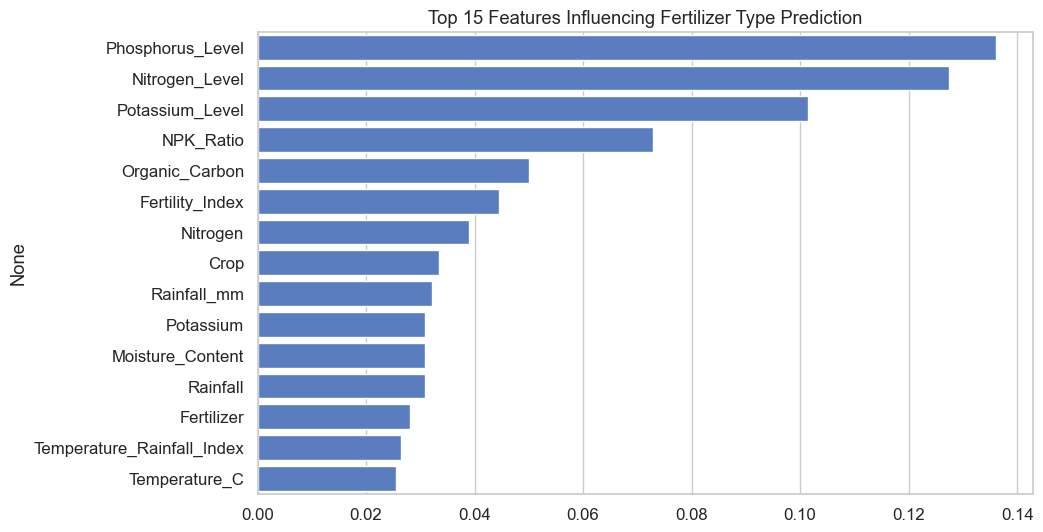

In [33]:
# =====================================================
# 9. Feature Importance Visualization
# =====================================================
importances = pd.Series(clf_rf.feature_importances_, index=X_train_clf.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title('Top 15 Features Influencing Fertilizer Type Prediction')
plt.show()

In [34]:
# =====================================================
# 10. Save Trained Models
# =====================================================
joblib.dump(clf_rf, MODELS / 'fertilizer_type_model.pkl')
joblib.dump(reg_rf, MODELS / 'fertilizer_quantity_model.pkl')
print(f"✅ Models saved to: {MODELS.resolve()}")

✅ Models saved to: C:\Users\sasik\OneDrive\Desktop\AIML Project\models


In [35]:
# =====================================================
# 11. Evaluate on Test Set
# =====================================================
X_test = test.drop(['Fertilizer_Type', 'Recommended_Quantity_kg_per_acre'], axis=1)
y_test_clf = test['Fertilizer_Type']
y_test_reg = test['Recommended_Quantity_kg_per_acre']
X_test = add_rule_features(X_test)

preds_clf_test = clf_rf.predict(X_test)
preds_reg_test = reg_rf.predict(X_test)

test_acc = accuracy_score(y_test_clf, preds_clf_test)
test_mae = mean_absolute_error(y_test_reg, preds_reg_test)
test_r2 = r2_score(y_test_reg, preds_reg_test)

print(f"\n✅ Test Accuracy (Classifier): {test_acc:.3f}")
print(f"✅ Test MAE (Regressor): {test_mae:.2f}")
print(f"✅ Test R² (Regressor): {test_r2:.3f}")

ValueError: could not convert string to float: 'Kolhapur'


✅ FINAL TEST PERFORMANCE — RANDOM FOREST MODELS
Classifier Accuracy: 0.820
Regressor MAE: 13.37
Regressor R²: 0.124

📊 Classification Report:
               precision    recall  f1-score   support

     Compost       1.00      0.93      0.96      1567
         DAP       0.85      0.54      0.66       186
       Mixed       0.33      0.79      0.47       201
      Potash       0.68      0.57      0.62       244
        Urea       0.80      0.64      0.71       291

    accuracy                           0.82      2489
   macro avg       0.73      0.69      0.69      2489
weighted avg       0.88      0.82      0.84      2489



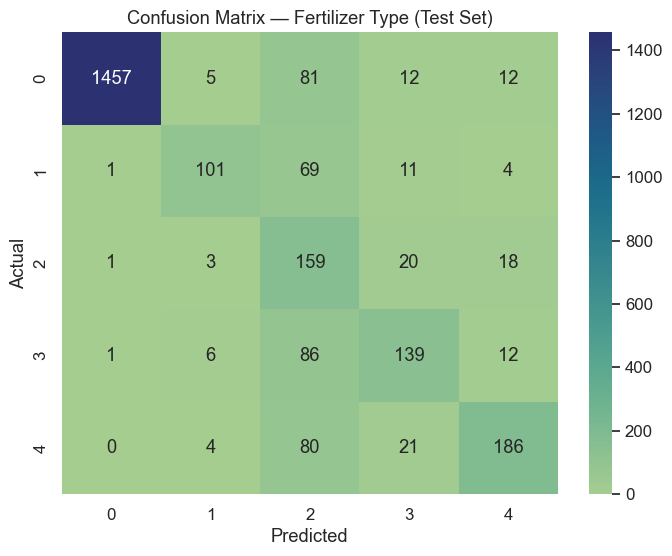

✅ Evaluation Complete — Test Results Successfully Generated!


In [36]:
# =====================================================
# 11. Evaluate on Test Set (Fixed for Text Columns)
# =====================================================
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, classification_report

# -----------------------------------------------------
# Apply Rule-Based Features (same as training)
# -----------------------------------------------------
X_test = test.drop(['Fertilizer_Type', 'Recommended_Quantity_kg_per_acre'], axis=1)
y_test_clf = test['Fertilizer_Type']
y_test_reg = test['Recommended_Quantity_kg_per_acre']
X_test = add_rule_features(X_test)

# -----------------------------------------------------
# Encode Test Data Using the SAME Encoders from Training
# -----------------------------------------------------
def apply_encoders(df, encoders):
    """Safely apply label encoders to test/validation datasets."""
    df_encoded = df.copy()
    for col, le in encoders.items():
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].astype(str)
            known_classes = set(le.classes_)
            df_encoded[col] = df_encoded[col].apply(
                lambda x: x if x in known_classes else list(known_classes)[0]
            )
            df_encoded[col] = le.transform(df_encoded[col])
    return df_encoded

# ✅ Encode test data
X_test_encoded = apply_encoders(X_test, encoders_clf)

# -----------------------------------------------------
# Make Predictions
# -----------------------------------------------------
preds_clf_test = clf_rf.predict(X_test_encoded)
preds_reg_test = reg_rf.predict(X_test_encoded)

# -----------------------------------------------------
# Evaluate Metrics
# -----------------------------------------------------
test_acc = accuracy_score(y_test_clf, preds_clf_test)
test_mae = mean_absolute_error(y_test_reg, preds_reg_test)
test_r2 = r2_score(y_test_reg, preds_reg_test)

print("\n✅ FINAL TEST PERFORMANCE — RANDOM FOREST MODELS")
print(f"Classifier Accuracy: {test_acc:.3f}")
print(f"Regressor MAE: {test_mae:.2f}")
print(f"Regressor R²: {test_r2:.3f}")

print("\n📊 Classification Report:\n", classification_report(y_test_clf, preds_clf_test))

# -----------------------------------------------------
# Optional — Confusion Matrix Visualization
# -----------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_clf, preds_clf_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.title('Confusion Matrix — Fertilizer Type (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("✅ Evaluation Complete — Test Results Successfully Generated!")
